In [1]:
%pylab inline
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


The code below is a copy of the actual code

In [52]:
class neuralnetwork(object):
    """Neural network of 3 layers"""
    def __init__(self, INPUTLAYERSIZE=2, H1LAYERSIZE=3,
                 H2LAYERSIZE=3, OUTPUTLAYERSIZE=1,
                 ERR=0.0001):
        # Constants
        self.INPUTLAYERSIZE = INPUTLAYERSIZE
        self.H1LAYERSIZE = H1LAYERSIZE
        self.H2LAYERSIZE = H2LAYERSIZE
        self.OUTPUTLAYERSIZE = OUTPUTLAYERSIZE
        self.ERR = 0.0001
        # Weights
        self.weight1 = np.random.rand(INPUTLAYERSIZE, H1LAYERSIZE)
        self.weight2 = np.random.rand(H1LAYERSIZE, H2LAYERSIZE)
        self.weight3 = np.random.rand(H2LAYERSIZE, OUTPUTLAYERSIZE)

    def foward(self, data, extended=False):
        """Fowards a input "data"
        Params:  self.foward(data, extended=False)
        If extended = True, returns outs, s3, a2, s2, a1, s1
        if extended = False, returns outs"""
        # First layer
        z1 = np.dot(data, self.weight1)
        a1 = self.ativation(z1)
        # Second layer
        z2 = np.dot(a1, self.weight2)
        a2 = self.ativation(z2)
        # Third layer
        z3 = np.dot(a2, self.weight3)
        outs = self.ativation(z3)

        if extended is True:
            return outs, z3, a2, z2, a1, z1  # Returns
        else:
            return outs

    def ativation(self, x):
        """Sigmoid of x"""
        return 1 / (1 + np.exp(-x))

    def derivativ(self, x):
        """Derivative sigmoid of x"""
        atvx = self.ativation(x)
        return atvx * (1 - atvx)

    def cost(self, trainData, tgtData):
        """Returns the error caused by the atual weights
        This code has overfitting prevention"""
        z3 = self.foward(trainData)
        return (sum((z3 - tgtData) ** 2)
                / (2 * trainData.shape[0])
                + (self.ERR / 2 )
                * (sum(self.weight1**2) + sum(self.weight2**2) + sum(self.weight3**2)))

    def primedcost(self, trainData, tgtData):
        """Calculates primed cost of Dcost/dW3, Dcost/dW2, Dcost/dW1"""
        outs, z3, a2, z2, a1, z1 = self.foward(trainData, extended=True)
        error = (outs - tgtData)
        NSHAPE = trainData.shape[0]
        
        # Calculating dCostdW3
        sigma3 = np.multiply(error, self.derivativ(z3))
        dCostdW3 = np.dot(a2.T, sigma3) / NSHAPE + self.ERR*self.weight3
        # Calculating dCostdW2
        sigma2 = np.dot(sigma3, self.weight3.T)
        sigma2 = sigma2 * self.derivativ(z2)
        dCostdW2 = np.dot(a1.T, sigma2) / NSHAPE + self.ERR*self.weight2
        # Calculating dCostdW1
        sigma1 = np.dot(sigma2, self.weight2.T)
        sigma1 = sigma1 * self.derivativ(z1)
        dCostdW1 = np.dot(trainData.T, sigma1) / NSHAPE + self.ERR*self.weight1

        return dCostdW3, dCostdW2, dCostdW1
    
    def organizeline(self, A, B, C):
        return np.concatenate((A.ravel(), B.ravel(), C.ravel()))
    
    def getweight(self):
        #Get W1 and W2 unrolled into vector:
        return self.organizeline(self.weight1, self.weight2, self.weight3)
    
    def setweight(self, params):
        # Set W1, W2 and W3 using single paramater vector.
        #W1
        W1START = 0
        W1END = self.INPUTLAYERSIZE * self.H1LAYERSIZE
        self.weight1 = params[W1START:W1END].reshape(self.INPUTLAYERSIZE, self.H1LAYERSIZE)
        #W2
        W2START = W1END
        W2END = W2START + (self.H1LAYERSIZE * self.H2LAYERSIZE)
        self.weight2 = params[W2START:W2END].reshape(self.H1LAYERSIZE, self.H2LAYERSIZE)
        #W3
        W3START = W2END
        W3END = W3START + (self.H2LAYERSIZE * self.OUTPUTLAYERSIZE)
        self.weight3 = params[W3START:W3END].reshape(self.H2LAYERSIZE, self.OUTPUTLAYERSIZE)
        
    def getgrad(self, traindata, tgtdata):
        dCostdW3, dCostdW2, dCostdW1 = self.primedcost(traindata, tgtdata)
        return self.organizeline(dCostdW1, dCostdW2, dCostdW3)
    
    
class trainer(object):
    def __init__(self, NN):
        self.NN = NN
        
    def getCostGrad(self, weights, X, Y):
        self.NN.setweight(weights)
        cost = self.NN.cost(X, Y)
        grad = self.NN.getgrad(X, Y)
        
        return cost, grad
    
    def train(self, trainData, tgtdata): 
        # Initial value for paramters
        params0 = self.NN.getweight()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.getCostGrad, params0, jac=True, method='BFGS', \
                                 args=(trainData, tgtdata), options=options)

        self.NN.setweight(_res.x)
        self.optresults = _res
    
neun = neuralnetwork()
train_neun = trainer(neun)

In [38]:
X = np.random.rand(5, 2)

Y = np.random.rand(5, 1)
X, Y

(array([[ 0.23822333,  0.67124781],
        [ 0.96187138,  0.85828384],
        [ 0.64909428,  0.96885628],
        [ 0.60361989,  0.66766613],
        [ 0.57493483,  0.16867046]]), array([[ 0.9268885 ],
        [ 0.66734224],
        [ 0.15356012],
        [ 0.99444601],
        [ 0.00851588]]))

In [53]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getweight()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setweight(paramsInitial + perturb)
            loss2 = N.cost(X, y)
            
            N.setweight(paramsInitial - perturb)
            loss1 = N.cost(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setweight(paramsInitial)

        return numgrad
    
numgrad = computeNumericalGradient(neun, X, Y)
grad = neun.getgrad(X, Y)
norm(grad-numgrad)/norm(grad+numgrad)

5.3112893625559618e-10

In [54]:
train_neun.train(X, Y)
train_neun.optresults.success

         Current function value: 0.028168
         Iterations: 200
         Function evaluations: 215
         Gradient evaluations: 215


False

<IPython.core.display.Javascript object>


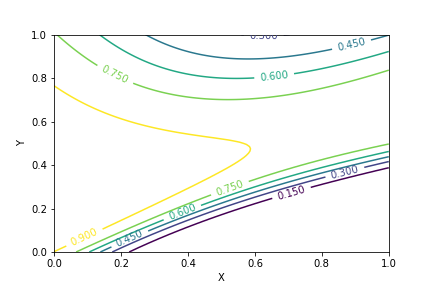

In [55]:
hX = linspace(0, 1, 100)
hY = linspace(0, 1, 100)

a, b  = meshgrid(hXN, hYN)

allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()
allOutputs = neun.foward(allInputs)

#Contour Plot:
yy = np.dot(hY.reshape(100,1), np.ones((1,100)))
xx = np.dot(hX.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('X')
ylabel('Y')

<IPython.core.display.Javascript object>


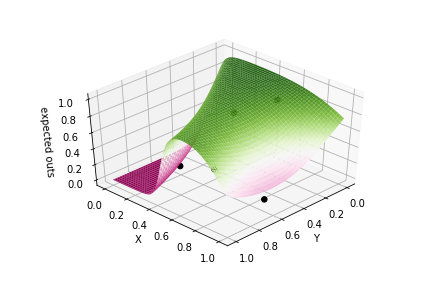

In [56]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(X[:,0], X[:,1], Y, c='k', alpha = 1, s=30)

surf = ax.plot_surface(xx, yy, allOutputs.reshape(100, 100), \
                       cmap=cm.PiYG)

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('expected outs')